In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OrdinalEncoder , OneHotEncoder

from sklearn.impute import SimpleImputer

from sklearn.compose import make_column_transformer , ColumnTransformer

from sklearn.pipeline import Pipeline , make_pipeline


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier



from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV


In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Daha hemen en başta özellikle Cabin kısmında çok fazla eksik veri olduğu görülüyor. Ayrıca object tipindeki verileri sayısal verilere çevirmemiz gerektiği de artık bilinmesi geren bir şey. Öte yandan head() ile veriya baktığımızda bazı sütunlarda ne olduğunu anlamak biraz zor ve modelin işlemesi için de pek uygun değerler yok gibi gözüküyor yani biraz feature engineering yapmamız gerekecek mesela aile üyeleri ; parents ayrı bir yerde kardeş ve eş kısmı ayrı bir yerde falan. Ayrıca mesela Name ksımından insanların ünvanlarını elde edebiliriz ve bu ünvanlardan yola çıkarak bir şeyler elde edebiliriz çünkü sadece isim kısmı neredeyse hiç işe yaramıyor veya ticket kısmı ilk haliyle baya anlamsız ancak düzenleyebiliriz belki. 

Bunlar veriyi ilk gördüğünde akla gelmesi gereken şeyler tabii ki yarışmaya katılmadan önce veri hakkında biraz bilgi edinmiş oluyoruz o yüzden bu yorumların çoğu zaten başlamadan yapılmalı strateji hemen hemen belli olmalı yani.



In [4]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [5]:
train_df.describe(include = ["O"])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


 "O" parametresi "object" türündeki (kategorik) verileri seçmek için kullanılır. Bu parametre, veri çerçevesindeki yalnızca kategorik sütunların istatistiklerini görmek için kullanılır.

Yani, describe() fonksiyonu ile kategorik sütunlardaki verilerin temel istatistiklerini (count, unique, top, ve freq) görebiliriz.

Mesela unique çok faydalı olabilir. 681 tane farklı bilet varmış mesela.

In [6]:
train_df.groupby(["Pclass"],as_index=False)["Survived"].mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [7]:
train_df.groupby(["Sex"], as_index = False)["Survived"].mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [8]:
train_df.groupby(["SibSp"],as_index=False)["Survived"].mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [9]:
train_df.groupby(['Parch'], as_index=False)['Survived'].mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [10]:
train_df["Family_Size"] = train_df["SibSp"] + train_df["Parch"] + 1
test_df["Family_Size"] = test_df["SibSp"] + test_df["Parch"] + 1

In [11]:
train_df.groupby(["Family_Size"],as_index=False)["Survived"].mean()

,Family_Size,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [12]:
family_map = {
             1: "Alone" ,
             2 : " Small" ,
             3 : "Small" ,
             4 : "Small" , 
             5 : "Medium" , 
             6 : "Medium" , 
             7 : "Large" ,
             8: 'Large', 
             11: 'Large'}

train_df["Family_Size_Grouped"] = train_df["Family_Size"].map(family_map)
test_df["Family_Size_Grouped"] = test_df["Family_Size"].map(family_map)


    

In [13]:
train_df.groupby(["Family_Size_Grouped"],as_index=False)["Survived"].mean()

,Family_Size_Grouped,Survived
0,Small,0.552795
1,Alone,0.303538
2,Large,0.160000
3,Medium,0.162162
4,Small,0.610687


In [14]:
train_df.groupby(["Embarked"], as_index=False)["Survived"].mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


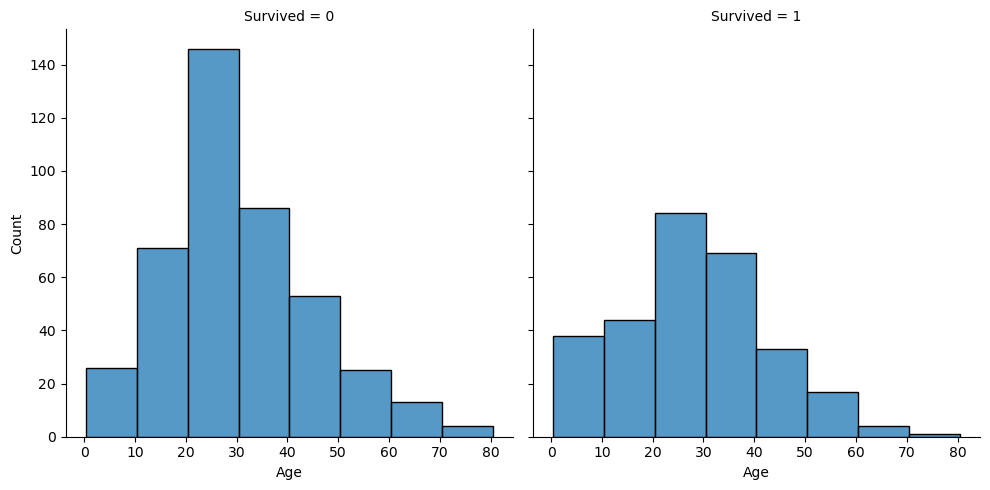

In [15]:
sns.displot(train_df , x = "Age" , col="Survived" , binwidth = 10 , height = 5);

bir dağılım(distribution plot) grafiği oluşturdum. grafiği oluştururken age sütunundaki verileri kullandım.
Survived sütununa göre verileri ayırdım ve her bir kategorideki dağılımları yan yana göstemek için col parametresini kullandım.

chatgpt açıklaması :

sns.displot(train_df, x="Age", col="Survived", binwidth=10, height=5):train_df veri çerçevesini kullanarak bir dağılım grafiği oluşturur.

x="Age": Grafiğin x ekseni için "Age" sütunundaki verileri kullanır.

col="Survived": Grafiği "Survived" sütununa göre ayrı kategorilere böler. Yani, grafiğin her bir sütunu, "Survived" sütununda 0 (hayatta kalmayanlar) ve 1 (hayatta kalanlar) değerlerine sahip verilere karşılık gelir.

binwidth=10: Histogram çubuklarının genişliğini belirtir. Her bir çubuk, belirli bir yaş aralığındaki veri noktalarını temsil eder.

height=5: Her alt grafik yüksekliğini belirler.


yaşın hayatta kalmaya olan etkisini görüyoruz burada.


In [16]:
train_df['Age_Cut'] = pd.qcut(train_df['Age'], 5)
test_df['Age_Cut'] = pd.qcut(test_df['Age'], 5)

qcut() fonksiyonu , verileri belirtilen sayıda eşit büyüklükte kategoriye böler. Burada Age sütunundaki yaş verilerini 5 eşit büyüklükte kategoriye bölüyoruz.



In [17]:
train_df.groupby(['Age_Cut'], as_index=False)['Survived'].mean()

,Age_Cut,Survived
0,"(0.419, 19.0]",0.481707
1,"(19.0, 25.0]",0.328467
2,"(25.0, 31.8]",0.393701
3,"(31.8, 41.0]",0.437500
4,"(41.0, 80.0]",0.373239


In [18]:
train_df.loc[train_df['Age'] <= 19, 'Age'] = 0
train_df.loc[(train_df['Age'] > 19) & (train_df['Age'] <= 25), 'Age'] = 1
train_df.loc[(train_df['Age'] > 25) & (train_df['Age'] <= 31.8), 'Age'] = 2
train_df.loc[(train_df['Age'] > 31.8) & (train_df['Age'] <= 41), 'Age'] = 3
train_df.loc[(train_df['Age'] > 41) & (train_df['Age'] <= 80), 'Age'] = 4
train_df.loc[train_df['Age'] > 80, 'Age'] 

test_df.loc[test_df['Age'] <= 19, 'Age'] = 0
test_df.loc[(test_df['Age'] > 19) & (test_df['Age'] <= 25), 'Age'] = 1
test_df.loc[(test_df['Age'] > 25) & (test_df['Age'] <= 31.8), 'Age'] = 2
test_df.loc[(test_df['Age'] > 31.8) & (test_df['Age'] <= 41), 'Age'] = 3
test_df.loc[(test_df['Age'] > 41) & (test_df['Age'] <= 80), 'Age'] = 4
test_df.loc[test_df['Age'] > 80, 'Age'] 

Series([], Name: Age, dtype: float64)

In [19]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Size_Grouped,Age_Cut
0,1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,7.2500,NaN,S,2,Small,"(19.0, 25.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,3.0,1,0,PC 17599,71.2833,C85,C,2,Small,"(31.8, 41.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,2.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Alone,"(25.0, 31.8]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,3.0,1,0,113803,53.1000,C123,S,2,Small,"(31.8, 41.0]"
4,5,0,3,"Allen, Mr. William Henry",male,3.0,0,0,373450,8.0500,NaN,S,1,Alone,"(31.8, 41.0]"


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


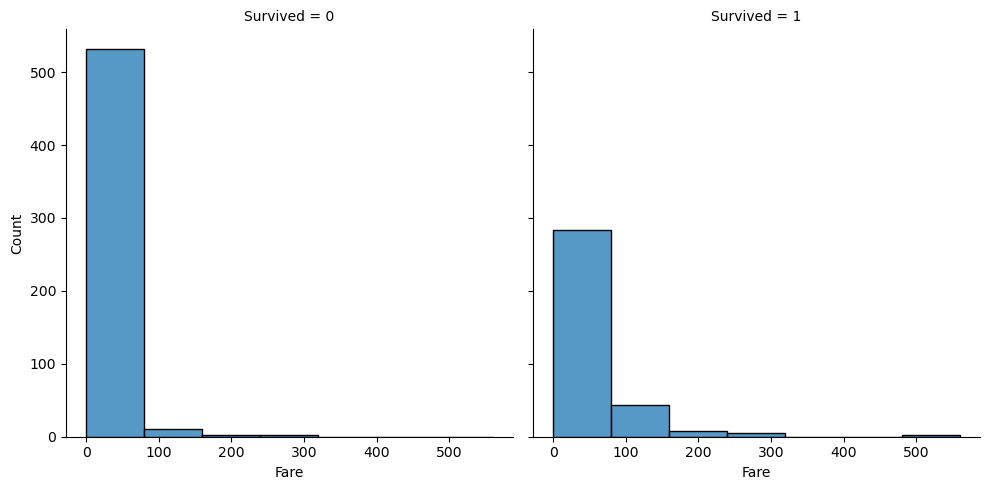

In [20]:
sns.displot(train_df , x="Fare" , col="Survived" , binwidth=80, height=5);

In [21]:
train_df["Fare_Cut"] = pd.qcut(train_df["Fare"] , 5)
test_df["Fare_Cut"] = pd.qcut(test_df["Fare"] , 5)


In [22]:
train_df.groupby(["Fare_Cut"],as_index=False).Survived.mean()

,Fare_Cut,Survived
0,"(-0.001, 7.854]",0.217877
1,"(7.854, 10.5]",0.201087
2,"(10.5, 21.679]",0.424419
3,"(21.679, 39.688]",0.444444
4,"(39.688, 512.329]",0.642045


Şaşırtıcı ki zengin olan arkadaşların hayatta kalma oranı yüksek. Acaba şaşırtıcı mı gerçekten?

In [23]:
train_df.loc[train_df['Fare'] <= 7.854, 'Fare'] = 0
train_df.loc[(train_df['Fare'] > 7.854) & (train_df['Fare'] <= 10.5), 'Fare'] = 1
train_df.loc[(train_df['Fare'] > 10.5) & (train_df['Fare'] <= 21.679), 'Fare'] = 2
train_df.loc[(train_df['Fare'] > 21.679) & (train_df['Fare'] <= 39.688), 'Fare'] = 3
train_df.loc[(train_df['Fare'] > 39.688) & (train_df['Fare'] <= 512.329), 'Fare'] = 4
train_df.loc[train_df['Fare'] > 512.329, 'Fare'] 

test_df.loc[test_df['Fare'] <= 7.854, 'Fare'] = 0
test_df.loc[(test_df['Fare'] > 7.854) & (test_df['Fare'] <= 10.5), 'Fare'] = 1
test_df.loc[(test_df['Fare'] > 10.5) & (test_df['Fare'] <= 21.679), 'Fare'] = 2
test_df.loc[(test_df['Fare'] > 21.679) & (test_df['Fare'] <= 39.688), 'Fare'] = 3
test_df.loc[(test_df['Fare'] > 39.688) & (test_df['Fare'] <= 512.329), 'Fare'] = 4
test_df.loc[test_df['Fare'] > 512.329, 'Fare'] 

343    512.3292
Name: Fare, dtype: float64

In [24]:
train_df['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [25]:
train_df['Title'] = train_df['Name'].str.split(pat= ",", expand=True)[1].str.split(pat= ".", expand=True)[0].apply(lambda x: x.strip())
test_df['Title'] = test_df['Name'].str.split(pat= ",", expand=True)[1].str.split(pat= ".", expand=True)[0].apply(lambda x: x.strip())

In [26]:
train_df.groupby(['Title'], as_index=False)['Survived'].mean()

,Title,Survived
0,Capt,0.000000
1,Col,0.500000
2,Don,0.000000
3,Dr,0.428571
4,Jonkheer,0.000000
5,Lady,1.000000
6,Major,0.500000
7,Master,0.575000
8,Miss,0.697802
9,Mlle,1.000000


#military - Capt, Colonel(Col), Major

#noble - Jonkheer, the Countess, Don, Lady, Sir

#unmaried Female - Mlle, Ms, Mme

In [27]:
train_df['Title'] = train_df['Title'].replace({
    'Capt': 'Military',
    'Col': 'Military',
    'Major': 'Military',
    'Jonkheer': 'Noble',
    'the Countess': 'Noble',
    'Don': 'Noble',
    'Lady': 'Noble',
    'Sir': 'Noble',
    'Mlle': 'Noble',
    'Ms': 'Noble',
    'Mme': 'Noble'    
})

test_df['Title'] = test_df['Title'].replace({
    'Capt': 'Military',
    'Col': 'Military',
    'Major': 'Military',
    'Jonkheer': 'Noble',
    'the Countess': 'Noble',
    'Don': 'Noble',
    'Lady': 'Noble',
    'Sir': 'Noble',
    'Mlle': 'Noble',
    'Ms': 'Noble',
    'Mme': 'Noble'    
})

In [28]:
train_df.groupby(["Title"],as_index=False)["Survived"].agg(["count","mean"])

,Title,count,mean
0,Dr,7,0.428571
1,Master,40,0.575000
2,Military,5,0.400000
3,Miss,182,0.697802
4,Mr,517,0.156673
5,Mrs,125,0.792000
6,Noble,9,0.777778
7,Rev,6,0.000000


In [29]:
train_df['Name_Length'] = train_df['Name'].apply(lambda x: len(x))
test_df['Name_Length'] = test_df['Name'].apply(lambda x: len(x))

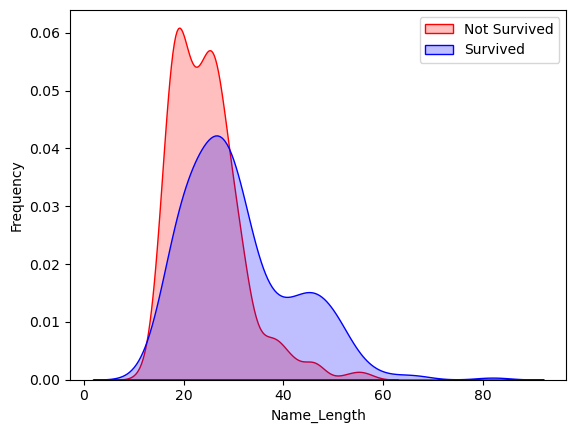

In [30]:
g = sns.kdeplot(train_df['Name_Length'][(train_df['Survived']==0) & (train_df['Name_Length'].notnull())], color='Red', fill=True)
g = sns.kdeplot(train_df['Name_Length'][(train_df['Survived']==1) & (train_df['Name_Length'].notnull())], ax=g, color='Blue', fill=True)
g.set_xlabel('Name_Length')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

isim uzunluklarıyla hayatta kalma ilişkilerini görselleştirdim.

kde = kernel denisty estimation

Bu grafiklerin çeşitli özelliklerinin hepsini akılda tutmak pek mümkün değil öünkü renklerden tut genişliğe ,arka plan tarzına bir sürü ıvır zıvır var .Ancak bunlar çok basit şeyler dökümana ufak bir göz gezdirerek her türlü tasarımı yapabiliriz.

DAha da iyisi bu grafik işlerinde ayrıntılar için ChatGPT kullan dediğim gibi bunlar basit şeyler sadece ezber bilgi gerektiriyor ve yapay zeka bilgi ezberlemede insandan çok daha iyi . Veya Stackoverflow da senin yapmak istediğin grafik çoktan yapılmıştır muhtemelen nasıl yapıldığına oraya gidip bakabilirsin ve ayrıca stackoverflow da senin grafiğe alternatif olanları da görme şansın olur.

In [31]:
train_df['Name_LengthGB'] = pd.qcut(train_df['Name_Length'], 3)
test_df['Name_LengthGB'] = pd.qcut(test_df['Name_Length'], 3)

In [32]:
train_df.groupby(['Name_LengthGB'], as_index=False)['Survived'].mean()

,Name_LengthGB,Survived
0,"(11.999, 22.0]",0.252336
1,"(22.0, 28.0]",0.322581
2,"(28.0, 82.0]",0.587629


In [33]:
train_df.loc[train_df['Name_Length'] <= 22, 'Name_Size'] = 0
train_df.loc[(train_df['Name_Length'] > 22) & (train_df['Name_Length'] <= 28), 'Name_Size'] = 1
train_df.loc[(train_df['Name_Length'] > 28) & (train_df['Name_Length'] <= 82), 'Name_Size'] = 2
train_df.loc[train_df['Name_Length'] > 82, 'Name_Size'] 

test_df.loc[test_df['Name_Length'] <= 22, 'Name_Size'] = 0
test_df.loc[(test_df['Name_Length'] > 22) & (test_df['Name_Length'] <= 28), 'Name_Size'] = 1
test_df.loc[(test_df['Name_Length'] > 28) & (test_df['Name_Length'] <= 82), 'Name_Size'] = 2
test_df.loc[test_df['Name_Length'] > 82, 'Name_Size'] 

Series([], Name: Name_Size, dtype: float64)

Burada aslında Name_Length sütunundaki isim uzunlukları yerine kategorik veriler oluşturmayı hedefliyorduk ama bir fikir değişkliğiyle yeni bir sütun oluşturduk adı Name_Size ve kategorik hale getirilmiş olan isim uzunluklarını bu sütunda tutmaya karar verdik. Sonuçta isim uzunluğunu görmenin çok da bir zararı yok yani.

Bu yöntemle yeni sütun oluşturmak biraz garip gelebilir ama yapılabiliyor işte.

In [34]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Size_Grouped,Age_Cut,Fare_Cut,Title,Name_Length,Name_LengthGB,Name_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,0.0,NaN,S,2,Small,"(19.0, 25.0]","(-0.001, 7.854]",Mr,23,"(22.0, 28.0]",1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,3.0,1,0,PC 17599,4.0,C85,C,2,Small,"(31.8, 41.0]","(39.688, 512.329]",Mrs,51,"(28.0, 82.0]",2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,2.0,0,0,STON/O2. 3101282,1.0,NaN,S,1,Alone,"(25.0, 31.8]","(7.854, 10.5]",Miss,22,"(11.999, 22.0]",0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,3.0,1,0,113803,4.0,C123,S,2,Small,"(31.8, 41.0]","(39.688, 512.329]",Mrs,44,"(28.0, 82.0]",2.0
4,5,0,3,"Allen, Mr. William Henry",male,3.0,0,0,373450,1.0,NaN,S,1,Alone,"(31.8, 41.0]","(7.854, 10.5]",Mr,24,"(22.0, 28.0]",1.0


In [35]:
train_df["Ticket"]

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [36]:
train_df['TicketNumber'] = train_df['Ticket'].apply(lambda x: pd.Series({'Ticket': x.split()[-1]}))
test_df['TicketNumber'] = test_df['Ticket'].apply(lambda x: pd.Series({'Ticket': x.split()[-1]}))

In [37]:
train_df.groupby(['TicketNumber'], as_index=False)['Survived'].agg(['count', 'mean']).sort_values('count', ascending=False)

,TicketNumber,count,mean
464,347082,7,0.000000
196,2343,7,0.000000
94,1601,7,0.714286
168,2144,6,0.000000
468,347088,6,0.000000
...,...,...,...
271,2662,1,0.000000
272,2663,1,1.000000
273,2664,1,0.000000
276,2667,1,1.000000


Burada bilet numaralarının sıklığını merak ediyoruz . Akıldaki soru şu : bilet numarası hayatta kalma oranını etkiliyor mu ? çünkü belki bilet numarasına göre farklı yerlerde bulunuyordur yolcular ve bulundukları yerlere göre yaşama olasılıkları yükselebilir veya düşebilir.

In [38]:
train_df.groupby('TicketNumber')['TicketNumber'].transform('count')

0      1
1      1
2      1
3      2
4      1
      ..
886    1
887    1
888    2
889    1
890    1
Name: TicketNumber, Length: 891, dtype: int64

In [39]:
train_df["TicketNumberCounts"]=train_df.groupby('TicketNumber')['TicketNumber'].transform('count')
test_df["TicketNumberCounts"]=test_df.groupby('TicketNumber')['TicketNumber'].transform('count')

her bir bileti (ticket) temsil eden numaraların, her bir bilet numarasının toplam adetini hesaplamak için kullanılıyor. Bu sayede, her bir bilet numarasının kaç kez tekrarlandığını belirlemiş oluyoruz.

aynı bilet numarasına sahip yolcuların sayısını belirleyerek, aynı bilet numarasına sahip yolcuların hayatta kalma oranlarını veya diğer özelliklerini karşılaştırabiliriz, yukarda açıkladım tekrar okurken zaten.


aşağıdaki kod tekrar sayılarına göre bir gruplama yapar ve her bir grup için hayatta kalma oranını hesaplar.

In [40]:
train_df.groupby(['TicketNumberCounts'], as_index=False)['Survived'].agg(['count', 'mean']).sort_values('count', ascending=False)

,TicketNumberCounts,count,mean
0,1,544,0.295956
1,2,188,0.569149
2,3,66,0.712121
3,4,44,0.500000
6,7,21,0.238095
5,6,18,0.000000
4,5,10,0.000000


Bu gruplama işlemi, bilet numaralarının tekrar sayısına göre bir kategorizasyon yapar ve her bir kategori için hayatta kalma oranını hesaplar.

mesela 1 numaralı bilete sahip 544 kişi varmış ve bunların hayatta kalma oranı %29 muş.

In [41]:
train_df["Ticket"]

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [42]:
train_df["Ticket"].str.split(pat = " ",expand = True)
# string fonksiyonlarından spliti uygula ve ayırdığın değerleri farklı sütunlara yay/genişlet/dağıt artık her neyse.

,0,1,2
0,A/5,21171,None
1,PC,17599,None
2,STON/O2.,3101282,None
3,113803,None,None
4,373450,None,None
...,...,...,...
886,211536,None,None
887,112053,None,None
888,W./C.,6607,None
889,111369,None,None


In [43]:
train_df["Ticket"].str.split(pat = " " , expand = True)[1]  # bu bizim bilet numaramızdı.

0        21171
1        17599
2      3101282
3         None
4         None
        ...   
886       None
887       None
888       6607
889       None
890       None
Name: 1, Length: 891, dtype: object

In [44]:
train_df['TicketLocation'] = np.where(train_df["Ticket"].str.split(pat = " " , expand = True)[1].notna() 
         , train_df['Ticket'].str.split( pat=" ", expand=True)[0].apply(lambda x: x.strip()), 'Blank')
# bilet numaralarını numpy arrayine aldık.

In [45]:
test_df['TicketLocation'] = np.where(test_df["Ticket"].str.split(pat = " " , expand = True)[1].notna() 
         , test_df['Ticket'].str.split( pat=" ", expand=True)[0].apply(lambda x: x.strip()), 'Blank')

###### np.where() fonksiyonu
**np.where(condition, x, y): Koşulun sağlanıp sağlanmadığını kontrol eder. Eğer koşul sağlanıyorsa, x değerini döndürür; aksi halde y değerini döndürür.

bir üstteki kodun anlamakta zorlanılabilecek kısımları için ChatGPT açıklaması : 

**'train_df['Ticket'].str.split(pat=" ", expand=True)[0].apply(lambda x: x.strip())':** İlk sütunda (indeks numarası 0) bulunan değerleri seçer, sonra her bir değeri strip() fonksiyonu ile başındaki ve sonundaki boşlukları kaldırır.

**'Blank'**: Eğer ikinci sütundaki değerler boş değilse, ilk sütundaki değerlerin başındaki ve sonundaki boşlukları kaldırarak elde edilen değeri alır. Eğer ikinci sütundaki değerler boşsa, "Blank" kelimesini kullanır.

In [46]:
train_df["TicketLocation"].value_counts()

TicketLocation
Blank         665
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
SOTON/OQ        7
A/5.            7
CA              6
STON/O2.        6
C               5
F.C.C.          5
S.O.C.          5
SC/PARIS        5
SC/Paris        4
S.O./P.P.       3
PP              3
A/4.            3
A/4             3
SC/AH           3
A./5.           2
SOTON/O2        2
A.5.            2
WE/P            2
S.C./PARIS      2
P/PP            2
F.C.            1
SC              1
S.W./PP         1
A/S             1
Fa              1
SCO/W           1
SW/PP           1
W/C             1
S.C./A.4.       1
S.O.P.          1
A4.             1
W.E.P.          1
SO/C            1
S.P.            1
C.A./SOTON      1
Name: count, dtype: int64

burada bazı şeyler birbiriyle aynı kategoriye sokulabliecek cinsten farkedersen mesela PARIS ve Paris var ve bazı lokasyonlar arasına nokta konulmuş ve bundan dolayı ayrılmmışlar ancak bunlar aynı yerler. Umarım net olmuştur. Kısaca aynı yerleri ifade eden ancak ayrı olarak listelenmiş lokasyonları map ile bir araya getirip gruplayalım.

ondan sonra biletleri aldıkları yerlere göre hayatta kalma oranlarına bir bakalım.

In [47]:
train_df['TicketLocation'] = train_df['TicketLocation'].replace({
    'SOTON/O.Q.':'SOTON/OQ',
    'C.A.':'CA',
    'CA.':'CA',
    'SC/PARIS':'SC/Paris',
    'S.C./PARIS':'SC/Paris',
    'A/4.':'A/4',
    'A/5.':'A/5',
    'A.5.':'A/5',
    'A./5.':'A/5',
    'W./C.':'W/C',    
})

test_df['TicketLocation'] = test_df['TicketLocation'].replace({
    'SOTON/O.Q.':'SOTON/OQ',
    'C.A.':'CA',
    'CA.':'CA',
    'SC/PARIS':'SC/Paris',
    'S.C./PARIS':'SC/Paris',
    'A/4.':'A/4',
    'A/5.':'A/5',
    'A.5.':'A/5',
    'A./5.':'A/5',
    'W./C.':'W/C',    
})

In [48]:
train_df.groupby(["TicketLocation"] , as_index=False)["Survived"].agg(["count","mean"])

,TicketLocation,count,mean
0,A/4,6,0.000000
1,A/5,21,0.095238
2,A/S,1,0.000000
3,A4.,1,0.000000
4,Blank,665,0.383459
5,C,5,0.400000
6,C.A./SOTON,1,0.000000
7,CA,41,0.341463
8,F.C.,1,0.000000
9,F.C.C.,5,0.800000


Evet her sütunu sevdik şimdi sıra geldi Cabin e . Hatırlarsak baya bi eksik verimi vardı o kısımda.

In [49]:
train_df['Cabin'] = train_df['Cabin'].fillna('U')
train_df['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'x' for i in train_df['Cabin']])

test_df['Cabin'] = test_df['Cabin'].fillna('U')
test_df['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'x' for i in test_df['Cabin']])

In [50]:
train_df.groupby(["Cabin"], as_index=False)["Survived"].agg(["count","mean"])
# burada as_index = Falsegiderse Cabin sütunu index olarak kalır.

,Cabin,count,mean
0,A,15,0.466667
1,B,47,0.744681
2,C,59,0.593220
3,D,33,0.757576
4,E,32,0.750000
5,F,13,0.615385
6,G,4,0.500000
7,T,1,0.000000
8,U,687,0.299854


elimizde kabin verisi olan ve olmayan yolcular olarak bölelim veri setini ve buna göre survived oranlarına bakalım.

In [51]:
train_df["Cabin_Assigned"] = train_df["Cabin"].apply(lambda x : 0 if x in ["U"] else 1 )
test_df['Cabin_Assigned'] = test_df['Cabin'].apply(lambda x: 0 if x in ['U'] else 1)

KABİNİ olan insanlar ve olmayan insanlar. daha doğrusu kabinini kaydettirmiş insanlar muhtamelen zengin idi gibi geliyor. Fakitler sadece gemiye binmiş işte kabinim nerde diye sormamış belki de .

In [52]:
train_df.groupby(["Cabin_Assigned"], as_index=False)["Survived"].agg(["count","mean"])

,Cabin_Assigned,count,mean
0,0,687,0.299854
1,1,204,0.666667


In [53]:
train_df.head().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,1.0,3.0,2.0,3.0,3.0
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,0.0,4.0,1.0,4.0,1.0


In [54]:
train_df.shape

(891, 24)

In [55]:
test_df.shape  # survived kolonu yok

(418, 23)

In [56]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          891 non-null    int64   
 1   Survived             891 non-null    int64   
 2   Pclass               891 non-null    int64   
 3   Name                 891 non-null    object  
 4   Sex                  891 non-null    object  
 5   Age                  714 non-null    float64 
 6   SibSp                891 non-null    int64   
 7   Parch                891 non-null    int64   
 8   Ticket               891 non-null    object  
 9   Fare                 891 non-null    float64 
 10  Cabin                891 non-null    object  
 11  Embarked             889 non-null    object  
 12  Family_Size          891 non-null    int64   
 13  Family_Size_Grouped  891 non-null    object  
 14  Age_Cut              714 non-null    category
 15  Fare_Cut             89

In [57]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Family_Size',
       'Family_Size_Grouped', 'Age_Cut', 'Fare_Cut', 'Title', 'Name_Length',
       'Name_LengthGB', 'Name_Size', 'TicketNumber', 'TicketNumberCounts',
       'TicketLocation', 'Cabin_Assigned'],
      dtype='object')

In [58]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          418 non-null    int64   
 1   Pclass               418 non-null    int64   
 2   Name                 418 non-null    object  
 3   Sex                  418 non-null    object  
 4   Age                  332 non-null    float64 
 5   SibSp                418 non-null    int64   
 6   Parch                418 non-null    int64   
 7   Ticket               418 non-null    object  
 8   Fare                 417 non-null    float64 
 9   Cabin                418 non-null    object  
 10  Embarked             418 non-null    object  
 11  Family_Size          418 non-null    int64   
 12  Family_Size_Grouped  418 non-null    object  
 13  Age_Cut              332 non-null    category
 14  Fare_Cut             417 non-null    category
 15  Title                41

In [59]:
train_df["Age"].fillna(train_df["Age"].mean(), inplace=True)
test_df["Age"].fillna(test_df["Age"].mean(), inplace=True)

test_df["Fare"].fillna(test_df["Fare"].mean(), inplace=True)
# test setinde 1 tane Fare eksikti , train de ise eksiklik yok.

Eksik verilerle ilgilenmenin farklı yolları da olabilir her geldiğinde farklı bir şey dene.

In [88]:
ohe = OneHotEncoder(sparse_output=False)
ode = OrdinalEncoder()
SI = SimpleImputer(strategy="most_frequent")
# embarked için mean kullanamdığımızdan dolyı bunu kullnıcaz. Teknik sebepler yani.


**OneHotEncoder(sparse_output=False)**: OneHotEncoder, kategorik (nominal) özellikleri alır ve her bir kategori için bir sütun oluşturur. Her bir sütun, o kategorinin varlığını (1) veya yokluğunu (0) temsil eder. sparse_output=False parametresi, kodun yoğun bir dizi (dense array) döndürmesini sağlar. Bu, daha okunabilir ve kullanılabilir bir çıktı sağlar.

**OrdinalEncoder**: OrdinalEncoder, kategorik (ordinal) özellikleri alır ve her bir kategoriye bir sayı atar. Bu atama, sıralı kategorilerin birbirleri arasındaki ilişkiyi temsil eder. Ancak, parantez içinde bir argüman olmaması normal değil, muhtemelen bir örnek oluşturulmamıştır. Doğru kullanım OrdinalEncoder() olmalıdır. Bu nedenle, bu kod satırının anlamı tam olarak net değildir.

**SimpleImputer(strategy="most_freq")**: SimpleImputer, eksik (NaN) değerleri doldurmak için kullanılır. strategy="most_freq" parametresi, eksik değerleri en sık görülen değerle doldurmayı ifade eder. Yani, eksik değerlerin yerine en sık görülen değerler atanır.

Bu kod parçaları, genellikle veri ön işleme aşamasında kullanılır. OneHotEncoder ve OrdinalEncoder kategorik özellikleri dönüştürmek için kullanılırken, SimpleImputer eksik değerleri doldurmak için kullanılır.

In [89]:
ode_cols = ['Family_Size_Grouped']
ohe_cols = ['Sex', 'Embarked']

ode için kullanacağımız sütunda bir sıralama var yani kendi aralarında sayısal olarak sıralı bunlar. Anahtar da bu.

ohe için kullandığımız featurelar ise kendi içlerinde bir rank barındırmıyor yani her birii farklı ve sayısal olarak kıyaslanamayacak durumdalar. One-hot bu kategorilerin her biri için ayrı bir sütun ekliyor DataFrame e

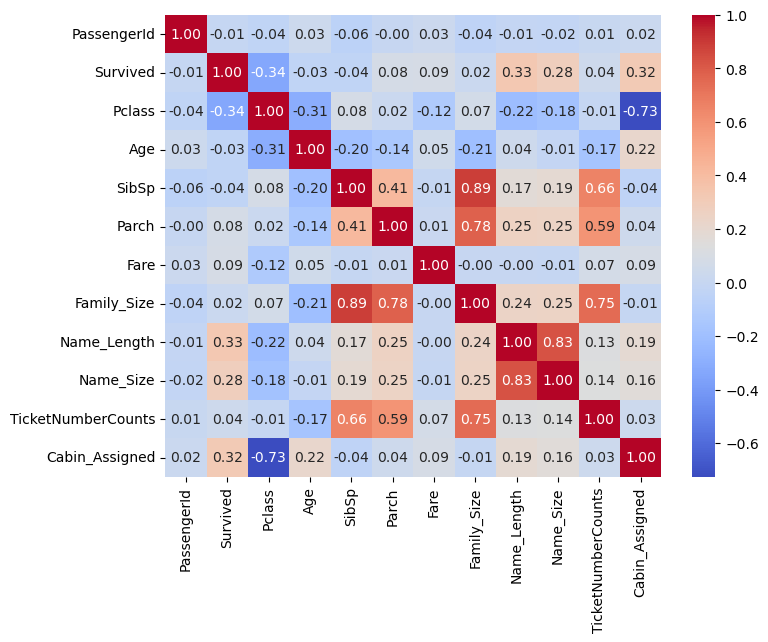

In [90]:
correlation_matrix = train_df.corr(numeric_only=True)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f");  
# grafik hoşuma gittiği içi olduğu gibi ekledim olmasa da çok bir zararı yok.

In [91]:
# Bu da denenebilir

#X = train_df.drop(['Survived'], axis=1)
#y = train_df['Survived']
#X_test = test_df.drop(['Age_Cut', 'Fare_Cut'], axis=1)  

# altta biraz daha iyi olduğunu düşündüğüm atama var.

In [92]:
X = train_df.drop(["Survived"],axis = 1)
y = train_df["Survived"]
X_test = test_df.drop(['Age_Cut', 'Fare_Cut', 'SibSp', 'Parch'], axis=1)
# burada aslında farklı farklı sütunları feature olarak ekleyip çıkarabilirsin böylece modeldeki farklılıkları görürsün.

In [93]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify = y, random_state=21)

stratify=y parametresi ,  sınıf dengesini korumak için kullanılır. Yani, bu parametre, eğitim ve doğrulama setlerindeki sınıf oranlarını orijinal veri setiyle aynı tutar. Bu özellik, özellikle dengesiz sınıfların olduğu sınıflandırma problemlerinde önemlidir


Örneğin, sınıf dengesizliği olan bir sınıflandırma problemi düşünelim. Diyelim ki veri setimizde iki sınıf var: "0" ve "1". Ancak, sınıf "0" çok daha fazla örneğe sahipken, sınıf "1" ise daha az örneğe sahip. Eğer bu veri setini rastgele ikiye bölersek, eğitim ve doğrulama setlerindeki sınıf dağılımı farklı olabilir. Bu durumda, model sınıf "1" örneklerini yeterince görmeyebilir ve bu sınıfı daha zor öğrenebilir.

Bu sorunu çözmek için "stratify" parametresi kullanılır. Bu parametre, veri setinin sınıf etiketlerini (yani, hedef değişkeni) belirtir. Veri setini bölerken, her iki setteki sınıf dağılımını orijinal veri setiyle aynı tutar. Yani, eğer sınıfların oranı %70-%30 ise, eğitim ve doğrulama setlerindeki sınıf oranı da aynı olur.

Bu sayede, model her iki sette de sınıf dağılımını doğru bir şekilde gözlemleyebilir ve öğrenebilir. Bu özellikle, dengesiz sınıf dağılımına sahip veri setlerinde model performansını artırmak için önemlidir.


Buradan sonra pipeline lar oluşturacağız. Bu kısım biraz zor gelebilir sorun yok zamanla oturur. bu kısım için bolca ChatGPT açıklaması ekleyebilirim belki sonrada silerim ancak hemen hemen her adımın bir açıklaması olsun istiyorum.

In [94]:
ordinal_pipeline = Pipeline(steps=[
    ("impute" , SimpleImputer(strategy="most_frequent")),
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value" , unknown_value=-1))
])

**Pipeline(steps=[...])**: Pipeline oluştururken, bu fonksiyonu kullanırız. Bu fonksiyon, ardışık olarak uygulanacak dönüşümleri ve tahmin modelini bir araya getirir.

**("impute", SimpleImputer(strategy="most_freq"))**: İlk adımda, eksik değerleri doldurmak için SimpleImputer kullanılır. strategy="most_freq" parametresi, eksik değerleri en sık gözlenen değerle doldurmayı belirtir. "impute" adı, bu dönüşümün adıdır ve sonraki adımlarda bu adı kullanarak bu dönüşüme başvurabiliriz.

**("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))**: İkinci adımda, kategorik (ordinal) özelliklerin kodlanması için OrdinalEncoder kullanılır. Bu dönüşüm, kategorik değerleri sayısal değerlere dönüştürür. **handle_unknown="use_encoded_value"** parametresi, bilinmeyen kategorik değerlerle karşılaşıldığında belirli bir kod kullanılmasını belirtir. **unknown_value=-1** parametresi ise, bilinmeyen kategorik değerler için kullanılacak olan kodu belirtir.

Bu pipeline, öncelikle eksik değerleri doldurur ve ardından kategorik özellikleri sayısal değerlere dönüştürür. Bu şekilde, veri setimiz modelin eğitimi için hazır hale gelir. Pipeline, bu işlemleri ardışık olarak uygular ve son adımda modelleme işlemine geçer. Bu, kodu daha düzenli ve okunabilir hale getirir ve tekrar kullanılabilirlik sağlar.

In [95]:
ohe_pipeline = Pipeline(steps=[
    ("impute",SimpleImputer(strategy="most_frequent")),
    ("one-hot" , OneHotEncoder(handle_unknown="ignore" , sparse_output=False))
    
])

**Pipeline(steps=[...])**: Yine, bir pipeline oluşturuyoruz ve içine adımları sıralıyoruz.

**("impute", SimpleImputer(strategy="most_freq"))**: İlk adımda, eksik değerleri doldurmak için SimpleImputer kullanılır. strategy="most_freq" parametresi, eksik değerleri en sık gözlenen değerle doldurmayı belirtir. "impute" adı, bu dönüşümün adıdır ve sonraki adımlarda bu adı kullanarak bu dönüşüme başvurabiliriz.

**("one-hot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))**: İkinci adımda, kategorik (nominal) özelliklerin kodlanması için OneHotEncoder kullanılır. Bu dönüşüm, kategorik değerleri çoklu sütunlar halinde (dummy variables) kodlar. handle_unknown="ignore" parametresi, bilinmeyen kategorik değerlerle karşılaşıldığında hata vermemesini belirtir. **sparse_output=False** parametresi, kodun yoğun bir dizi (dense array) döndürmesini sağlar.

Bu pipeline, öncelikle eksik değerleri doldurur ve ardından kategorik (nominal) özellikleri çoklu sütunlar halinde kodlar. Bu sayede, kategorik özellikler model tarafından anlaşılabilir hale gelir ve modelin eğitimi için uygun bir formata dönüşür.

In [96]:
col_trans = ColumnTransformer(transformers=[
    ("impute" , SI , ["Age"]),
    ("ord_pipeline" , ordinal_pipeline , ode_cols),
    ("ohe_pipeline" , ohe_pipeline,ohe_cols),
    ("passthrough" , "passthrough",["Pclass","Cabin_Assigned","Name_Size","Age","Fare","TicketNumberCounts"]),
    
    ],
                              remainder = "drop",
                              n_jobs=-1
                              
                             )


1. `ColumnTransformer(transformers=[...])`: ColumnTransformer, sütunları farklı dönüşümlerle dönüştürmek için kullanılır. Bu, farklı sütunlara farklı dönüşümler uygulamamızı sağlar.


2. `('impute', SI, ['Age'])`: "impute" adında bir dönüşüm tanımlanır. Bu dönüşüm, "Age" sütununda bulunan eksik değerleri doldurmak için `SimpleImputer` (SI) kullanır. Yani, "Age" sütunundaki eksik değerler bu dönüşüm ile doldurulur.


3. `('ord_pipeline', ordinal_pipeline, ode_cols)`: "ord_pipeline" adında bir dönüşüm tanımlanır. Bu dönüşüm, "ode_cols" adlı sütunlara "ordinal_pipeline" adındaki pipeline'ı uygular. Yani, belirtilen sütunlardaki kategorik (ordinal) özellikler bu pipeline ile işlenir.


4. `('ohe_pipeline', ohe_pipeline, ohe_cols)`: "ohe_pipeline" adında bir dönüşüm tanımlanır. Bu dönüşüm, "ohe_cols" adlı sütunlara "ohe_pipeline" adındaki pipeline'ı uygular. Yani, belirtilen sütunlardaki kategorik (nominal) özellikler bu pipeline ile işlenir.


5. `('passthrough', 'passthrough', ['Pclass', 'Cabin_Assigned', 'Name_Size', 'Age', 'Fare', 'TicketNumberCounts'])`: "passthrough" adında bir dönüşüm tanımlanır. Bu dönüşüm, belirtilen sütunlarda herhangi bir dönüşüm yapmadan sadece geçişi sağlar. Yani, "Pclass", "Cabin_Assigned", "Name_Size", "Age", "Fare" ve "TicketNumberCounts" sütunlarına herhangi bir dönüşüm uygulanmaz ve orijinal halleriyle kalır.


6. `remainder='drop'`: "remainder" parametresi, belirtilen sütunların dışındaki sütunların nasıl işleneceğini belirtir. "drop" parametresi, belirtilen sütunların dışındaki sütunların tamamen atılmasını sağlar.


7. `n_jobs=-1`: Bu parametre, işlemci çekirdeklerinin tamamını kullanarak dönüşümleri paralel olarak gerçekleştirmeyi sağlar. `-1` değeri, mevcut tüm işlemci çekirdeklerini kullanmayı ifade eder.


Bu ColumnTransformer, farklı sütunlara farklı dönüşümler uygular ve veri setini bu şekilde hazırlar. Bu sayede, farklı türdeki özelliklerin aynı anda işlenmesini sağlar ve daha kompleks bir ön işleme adımı gerçekleştirir.

In [97]:
rfc = RandomForestClassifier()

In [98]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [99]:
param_grid = {
    "n_estimators" : [150, 200, 300, 500],
    "min_samples_split" : [5, 10, 15],
    "max_depth" : [10, 13, 15, 17, 20],
    "min_samples_leaf"  : [2, 4, 5, 6],
    "criterion" : ['gini', 'entropy']
    
    
}

**"n_estimators"**: Bu parametre, RandomForestClassifier'da kullanılacak olan ağaç sayısını belirler. Her bir ağaç, veri setinin bir alt örneğini (bootstrap örnekleme ile seçilen) kullanarak eğitilir. Birden fazla ağaç kullanmak, modelin daha genelleştirilmiş ve daha iyi performans göstermesini sağlayabilir.

**"min_samples_split"**: Bu parametre, bir iç düğümün iki alt düğüme bölünmesi için gereken minimum örnek sayısını belirler. Küçük değerler, modelin aşırı öğrenme eğilimine karşı daha hassas olmasını sağlar, ancak daha büyük değerler daha az dallanmış ağaçlar oluşturur.

**"max_depth"**: Bu parametre, ağaçların maksimum derinliğini belirler. Derin ağaçlar daha karmaşık ilişkileri modelleyebilir, ancak aşırı öğrenme riski taşır. Daha düşük bir maksimum derinlik, daha basit modeller oluştururken, daha yüksek bir maksimum derinlik daha karmaşık modeller oluşturur.

**"min_samples_leaf"**: Bu parametre, bir yaprak düğümünde gereken minimum örnek sayısını belirler. Daha küçük bir değer, daha fazla dallanmış ağaçlar ve daha büyük bir değer daha az dallanmış ağaçlar oluşturur.

**"criterion"**: Bu parametre, ağaçların bölünmesi için kullanılacak olan kriteri belirler. "gini" ve "entropy" seçenekleri vardır. Gini impurity ve entropy (bilgi kazancı) yöntemleriyle bölünmeleri değerlendiririz.

In [100]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5) , n_jobs=-1 , verbose = 2)

In [101]:
pipefinalrfc = make_pipeline(col_trans, CV_rfc)
pipefinalrfc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=RandomForestClassifier(), n_jobs=-1,
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [10, 13, 15, 17, 20],
                                          'min_samples_leaf': [2, 4, 5, 6],
                                          'min_samples_split': [5, 10, 15],
                                          'n_estimators': [150, 200, 300,
                                                           500]}))])

In [102]:
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 500}
0.8244065793361568


In [103]:
dtc = DecisionTreeClassifier()

In [104]:
param_grid = {
    'min_samples_split': [5, 10, 15],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
}

In [105]:
CV_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5) , n_jobs=-1 , verbose = 2)

In [106]:
pipefinaldtc = make_pipeline(col_trans, CV_dtc)
pipefinaldtc.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=DecisionTreeClassifier(), n_jobs=-1,
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [10, 20, 30],
                                          'min_samples_leaf': [1, 2, 4],
                                          'min_samples_split': [5, 10, 15]},
                              verbose=2))])

In [107]:
print(CV_dtc.best_params_)
print(CV_dtc.best_score_)

{'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 15}
0.8075938146360683


In [108]:
knn = KNeighborsClassifier()

In [109]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1,2],
}

In [110]:
CV_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=StratifiedKFold(n_splits=5) , n_jobs=-1 , verbose = 2)

In [111]:
pipefinalknn = make_pipeline(col_trans, CV_knn)
pipefinalknn.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=KNeighborsClassifier(), n_jobs=-1,
                              param_grid={'algorithm': ['auto', 'ball_tree',
                                                        'kd_tree', 'brute'],
                                          'n_neighbors': [3, 5, 7, 9, 11],
                                          'p': [1, 2],
                                          'weights': ['uniform', 'distance']},
                              verbose=2))])

In [112]:
print(CV_knn.best_params_)
print(CV_knn.best_score_)

{'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.8061656653205949


In [113]:
svc = SVC(probability=True)

In [114]:
param_grid = {
    'C': [100,10, 1.0, 0.1, 0.001, 0.001],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
}

In [115]:
CV_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5) , n_jobs=-1 , verbose = 2)

In [116]:
pipefinalsvc = make_pipeline(col_trans, CV_svc)
pipefinalsvc.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=SVC(probability=True), n_jobs=-1,
                              param_grid={'C': [100, 10, 1.0, 0.1, 0.001,
                                                0.001],
                                          'kernel': ['linear', 'poly', 'rbf',
                                                     'sigmoid']},
                              verbose=2))])

In [117]:
print(CV_svc.best_params_)
print(CV_svc.best_score_)

{'C': 10, 'kernel': 'rbf'}
0.7977445090121147


In [118]:
lr = LogisticRegression()

In [119]:
param_grid = {
    'C': [100,10, 1.0, 0.1, 0.001, 0.001],
}

In [120]:
CV_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv=StratifiedKFold(n_splits=5) , n_jobs=-1 , verbose = 2)

In [121]:
pipefinallr= make_pipeline(col_trans, CV_lr)
pipefinallr.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=LogisticRegression(), n_jobs=-1,
                              param_grid={'C': [100, 10, 1.0, 0.1, 0.001,
                                                0.001]},
                              verbose=2))])

In [122]:
print(CV_lr.best_params_)
print(CV_lr.best_score_)

{'C': 1.0}
0.8061952132374668


In [123]:
gnb = GaussianNB()

In [124]:
param_grid = {
    'var_smoothing': [0.00000001, 0.000000001, 0.00000001],
}

In [125]:
CV_gnb = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=StratifiedKFold(n_splits=5) , n_jobs=-1 , verbose = 2)

In [126]:
pipefinalgnb= make_pipeline(col_trans, CV_gnb)
pipefinalgnb.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=GaussianNB(), n_jobs=-1,
                              param_grid={'var_smoothing': [1e-08, 1e-09,
                                                            1e-08]},
                              verbose=2))])

In [127]:
print(CV_gnb.best_params_)
print(CV_gnb.best_score_)

{'var_smoothing': 1e-08}
0.7640697330838175


In [128]:
xg = XGBClassifier()

In [129]:
param_grid = {
     'booster': ['gbtree', 'gblinear','dart'],
}

In [130]:
CV_xg = GridSearchCV(estimator=xg, param_grid=param_grid, cv=StratifiedKFold(n_splits=5) , n_jobs=-1 , verbose = 2)

In [131]:
pipefinalxg= make_pipeline(col_trans, CV_xg)
pipefinalxg.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...),
                              n_jobs=-1,
                              param_grid={'booster': ['gbtree', 'gblinear',
                                                      'dart']},
                              verbose=2))])

In [132]:
print(CV_xg.best_params_)
print(CV_xg.best_score_)

{'booster': 'gblinear'}
0.8047867625332413


In [133]:
abc = AdaBoostClassifier()

In [134]:
dtc_2 = DecisionTreeClassifier(criterion = 'entropy', max_depth=10,min_samples_leaf=4, min_samples_split=10)  
svc_2 = SVC(probability=True, C=10, kernel='rbf') 
lr_2 = LogisticRegression(C=0.1) 
lr_3 = LogisticRegression(C=0.2) 
lr_4 = LogisticRegression(C=0.05) 

In [135]:
param_grid = {
    'estimator': [dtc_2, svc_2, lr_2], 
    'n_estimators':  [5, 10, 25, 50, 100],
    'algorithm': ['SAMME', 'SAMME.R'],
    'learning_rate': [(0.97 + x / 100) for x in range(1, 7)]  
}

In [136]:
CV_abc = GridSearchCV(estimator=abc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5) , n_jobs=-1 , verbose = 2)

In [137]:
pipefinalabc= make_pipeline(col_trans, CV_abc)
pipefinalabc.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=AdaBoostClassifier(), n_jobs=-1,
                              param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                                          'estimator': [DecisionTreeClassifier(criterion='entropy',
                                                                               max_depth=10,
                                                                               min_samples_leaf=4,
                                                                               min_samples_split=10),
                                                        SVC(C=10,
                                                            probability=True),
                                                        LogisticRegression(C=0.1)],
                                          'learning_rate': [0.98, 0.99, 1.0,
                                                            1.01, 1.02, 1.03],
                                          'n_estimators': [5, 10, 25, 50, 100]},
                              verbose=2))])

In [138]:
print(CV_abc.best_params_)
print(CV_abc.best_score_)

{'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4,
                       min_samples_split=10), 'learning_rate': 1.02, 'n_estimators': 10}
0.7977346597064907


In [139]:
etc = ExtraTreesClassifier()

In [140]:
param_grid = {
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "n_estimators" :[100,300],
}

In [141]:
CV_etc = GridSearchCV(estimator=etc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5) , n_jobs=-1 , verbose = 2)

In [142]:
pipefinaletc= make_pipeline(col_trans, CV_etc)
pipefinaletc.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=ExtraTreesClassifier(), n_jobs=-1,
                              param_grid={'max_features': [1, 3, 10],
                                          'min_samples_leaf': [1, 3, 10],
                                          'min_samples_split': [2, 3, 10],
                                          'n_estimators': [100, 300]},
                              verbose=2))])

In [143]:
print(CV_etc.best_params_)
print(CV_etc.best_score_)

{'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 300}
0.8117994681374965


In [144]:
GBC = GradientBoostingClassifier()

In [145]:
param_grid = {
              'n_estimators' : [300, 400, 500],
              'learning_rate': [ 0.1, 0.3, 0.6, 1.0],
              'max_depth': [8, 10, 12],
              'min_samples_leaf': [50, 100, 120, 150],
              'max_features': [0.1, 0.3, 0.5] 
              }

In [146]:
CV_gbc = GridSearchCV(estimator=GBC, param_grid=param_grid, cv=StratifiedKFold(n_splits=5) , n_jobs=-1 , verbose = 2)

In [147]:
pipefinalgbc= make_pipeline(col_trans, CV_gbc)
pipefinalgbc.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=GradientBoostingClassifier(), n_jobs=-1,
                              param_grid={'learning_rate': [0.1, 0.3, 0.6, 1.0],
                                          'max_depth': [8, 10, 12],
                                          'max_features': [0.1, 0.3, 0.5],
                                          'min_samples_leaf': [50, 100, 120,
                                                               150],
                                          'n_estimators': [300, 400, 500]},
                              verbose=2))])

In [148]:
print(CV_gbc.best_params_)
print(CV_gbc.best_score_)

{'learning_rate': 0.3, 'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 120, 'n_estimators': 400}
0.8230473751600511


In [149]:
vc1 = VotingClassifier([('gbc', CV_gbc.best_estimator_),
                        ('etc', CV_etc.best_estimator_),
                          ('nb', CV_gnb.best_estimator_)
                         ], voting='hard', weights=[1,2,3] )

In [150]:
vc2 = VotingClassifier([('abc', CV_abc.best_estimator_),
                        ('etc', CV_etc.best_estimator_),
                          ('nb', CV_gnb.best_estimator_)
                         ], voting='hard', weights=[1,2,3] )
#1,2,3 is the best performing one

In [155]:
pipefinalcv1 = make_pipeline(col_trans, vc1)

In [156]:
pipefinalcv2 = make_pipeline(col_trans, vc2)

In [157]:
pipefinalcv1.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                   'TicketNumberCounts'])])),
                ('votingclassifier',
                 VotingClassifier(estimators=[('gbc',
                                               GradientBoostingClassifier(learning_rate=0.3,
                                                                          max_depth=8,
                                                                          max_features=0.5,
                                                                          min_samples_leaf=120,
                                                                          n_estimators=400)),
                                              ('etc',
                                               ExtraTreesClassifier(max_features=1,
                                                                    min_samples_leaf=3,
                                                                    min_samples_split=3,
                                                                    n_estimators=300)),
                                              ('nb',
                                               GaussianNB(var_smoothing=1e-08))],
                                  weights=[1, 2, 3]))])

In [158]:
pipefinalcv2.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                 VotingClassifier(estimators=[('abc',
                                               AdaBoostClassifier(algorithm='SAMME',
                                                                  estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                                   max_depth=10,
                                                                                                   min_samples_leaf=4,
                                                                                                   min_samples_split=10),
                                                                  learning_rate=1.02,
                                                                  n_estimators=10)),
                                              ('etc',
                                               ExtraTreesClassifier(max_features=1,
                                                                    min_samples_leaf=3,
                                                                    min_samples_split=3,
                                                                    n_estimators=300)),
                                              ('nb',
                                               GaussianNB(var_smoothing=1e-08))],
                                  weights=[1, 2, 3]))])

In [159]:
Y_pred = pipefinalrfc.predict(X_test)
Y_pred2 = pipefinaldtc.predict(X_test)
Y_pred3 = pipefinalknn.predict(X_test)
Y_pred4 = pipefinalsvc.predict(X_test)
Y_pred5 = pipefinallr.predict(X_test)
Y_pred6 = pipefinalgnb.predict(X_test)
Y_pred7 = pipefinalxg.predict(X_test)
Y_pred8 = pipefinalabc.predict(X_test)
Y_pred9 = pipefinaletc.predict(X_test)
Y_pred10 = pipefinalgbc.predict(X_test)
Y_pred11 = pipefinalcv1.predict(X_test)
Y_pred12 = pipefinalcv2.predict(X_test)

In [160]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred
})

submission2 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred2
})

submission3 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred3
})

submission4 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred4
})

submission5 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred5
})

submission6 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred6
})

submission7 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred7
})

submission8 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred8
})

submission9 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred9
})

submission10 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred10
})

submission11 = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred11
})

submission12 = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred12
})

In [162]:
submission.to_csv('Out/submission929_1.csv', index=False)
submission2.to_csv('Out/submission929_2.csv', index=False)
submission3.to_csv('Out/submission929_3.csv', index=False)
submission4.to_csv('Out/submission929_4.csv', index=False)
submission5.to_csv('Out/submission929_5.csv', index=False)
submission6.to_csv('Out/submission929_6.csv', index=False)
submission7.to_csv('Out/submission929_7.csv', index=False)
submission8.to_csv('Out/submission101_8.csv', index=False)
submission9.to_csv('Out/submission101_9.csv', index=False)
submission10.to_csv('Out/submission101_10.csv', index=False)
submission11.to_csv('Out/submission101_11.csv', index=False)
submission12.to_csv('Out/submission101_12.csv', index=False)